![](img/logo.png)

# Decision Tree
## Yoav Ram

A decision tree makes decision (or predictions) similar to a flow chart:

![flow chart](https://farm3.static.flickr.com/2558/5715300721_6bc07e7c3f_b.jpg)

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.metrics import accuracy_score, r2_score

from sklearn.datasets import load_boston

from yellowbrick.classifier import class_prediction_error
from yellowbrick.regressor import residuals_plot, prediction_error
from yellowbrick.model_selection import feature_importances ,validation_curve

import warnings
warnings.simplefilter("ignore", FutureWarning)

red, blue, green = sns.color_palette('Set1', 3)
sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

# Data 

We will use the [Pima diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database), originally from the National Institute of Diabetes and Digestive and Kidney Diseases..

The data contains several physiological and demographic features from which we want to predict if the patient has diabetes.

In [2]:
df = pd.read_csv("../data/pima-indians-diabetes.csv")
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [3]:
features = ['Pregnancies', 'Insulin', 'BMI', 'Age','Glucose','BloodPressure','DiabetesPedigreeFunction']
X = df[features].values # Features
y = df['Outcome'].values # Target variable

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

## Data exploration

Let's have a look at the data.

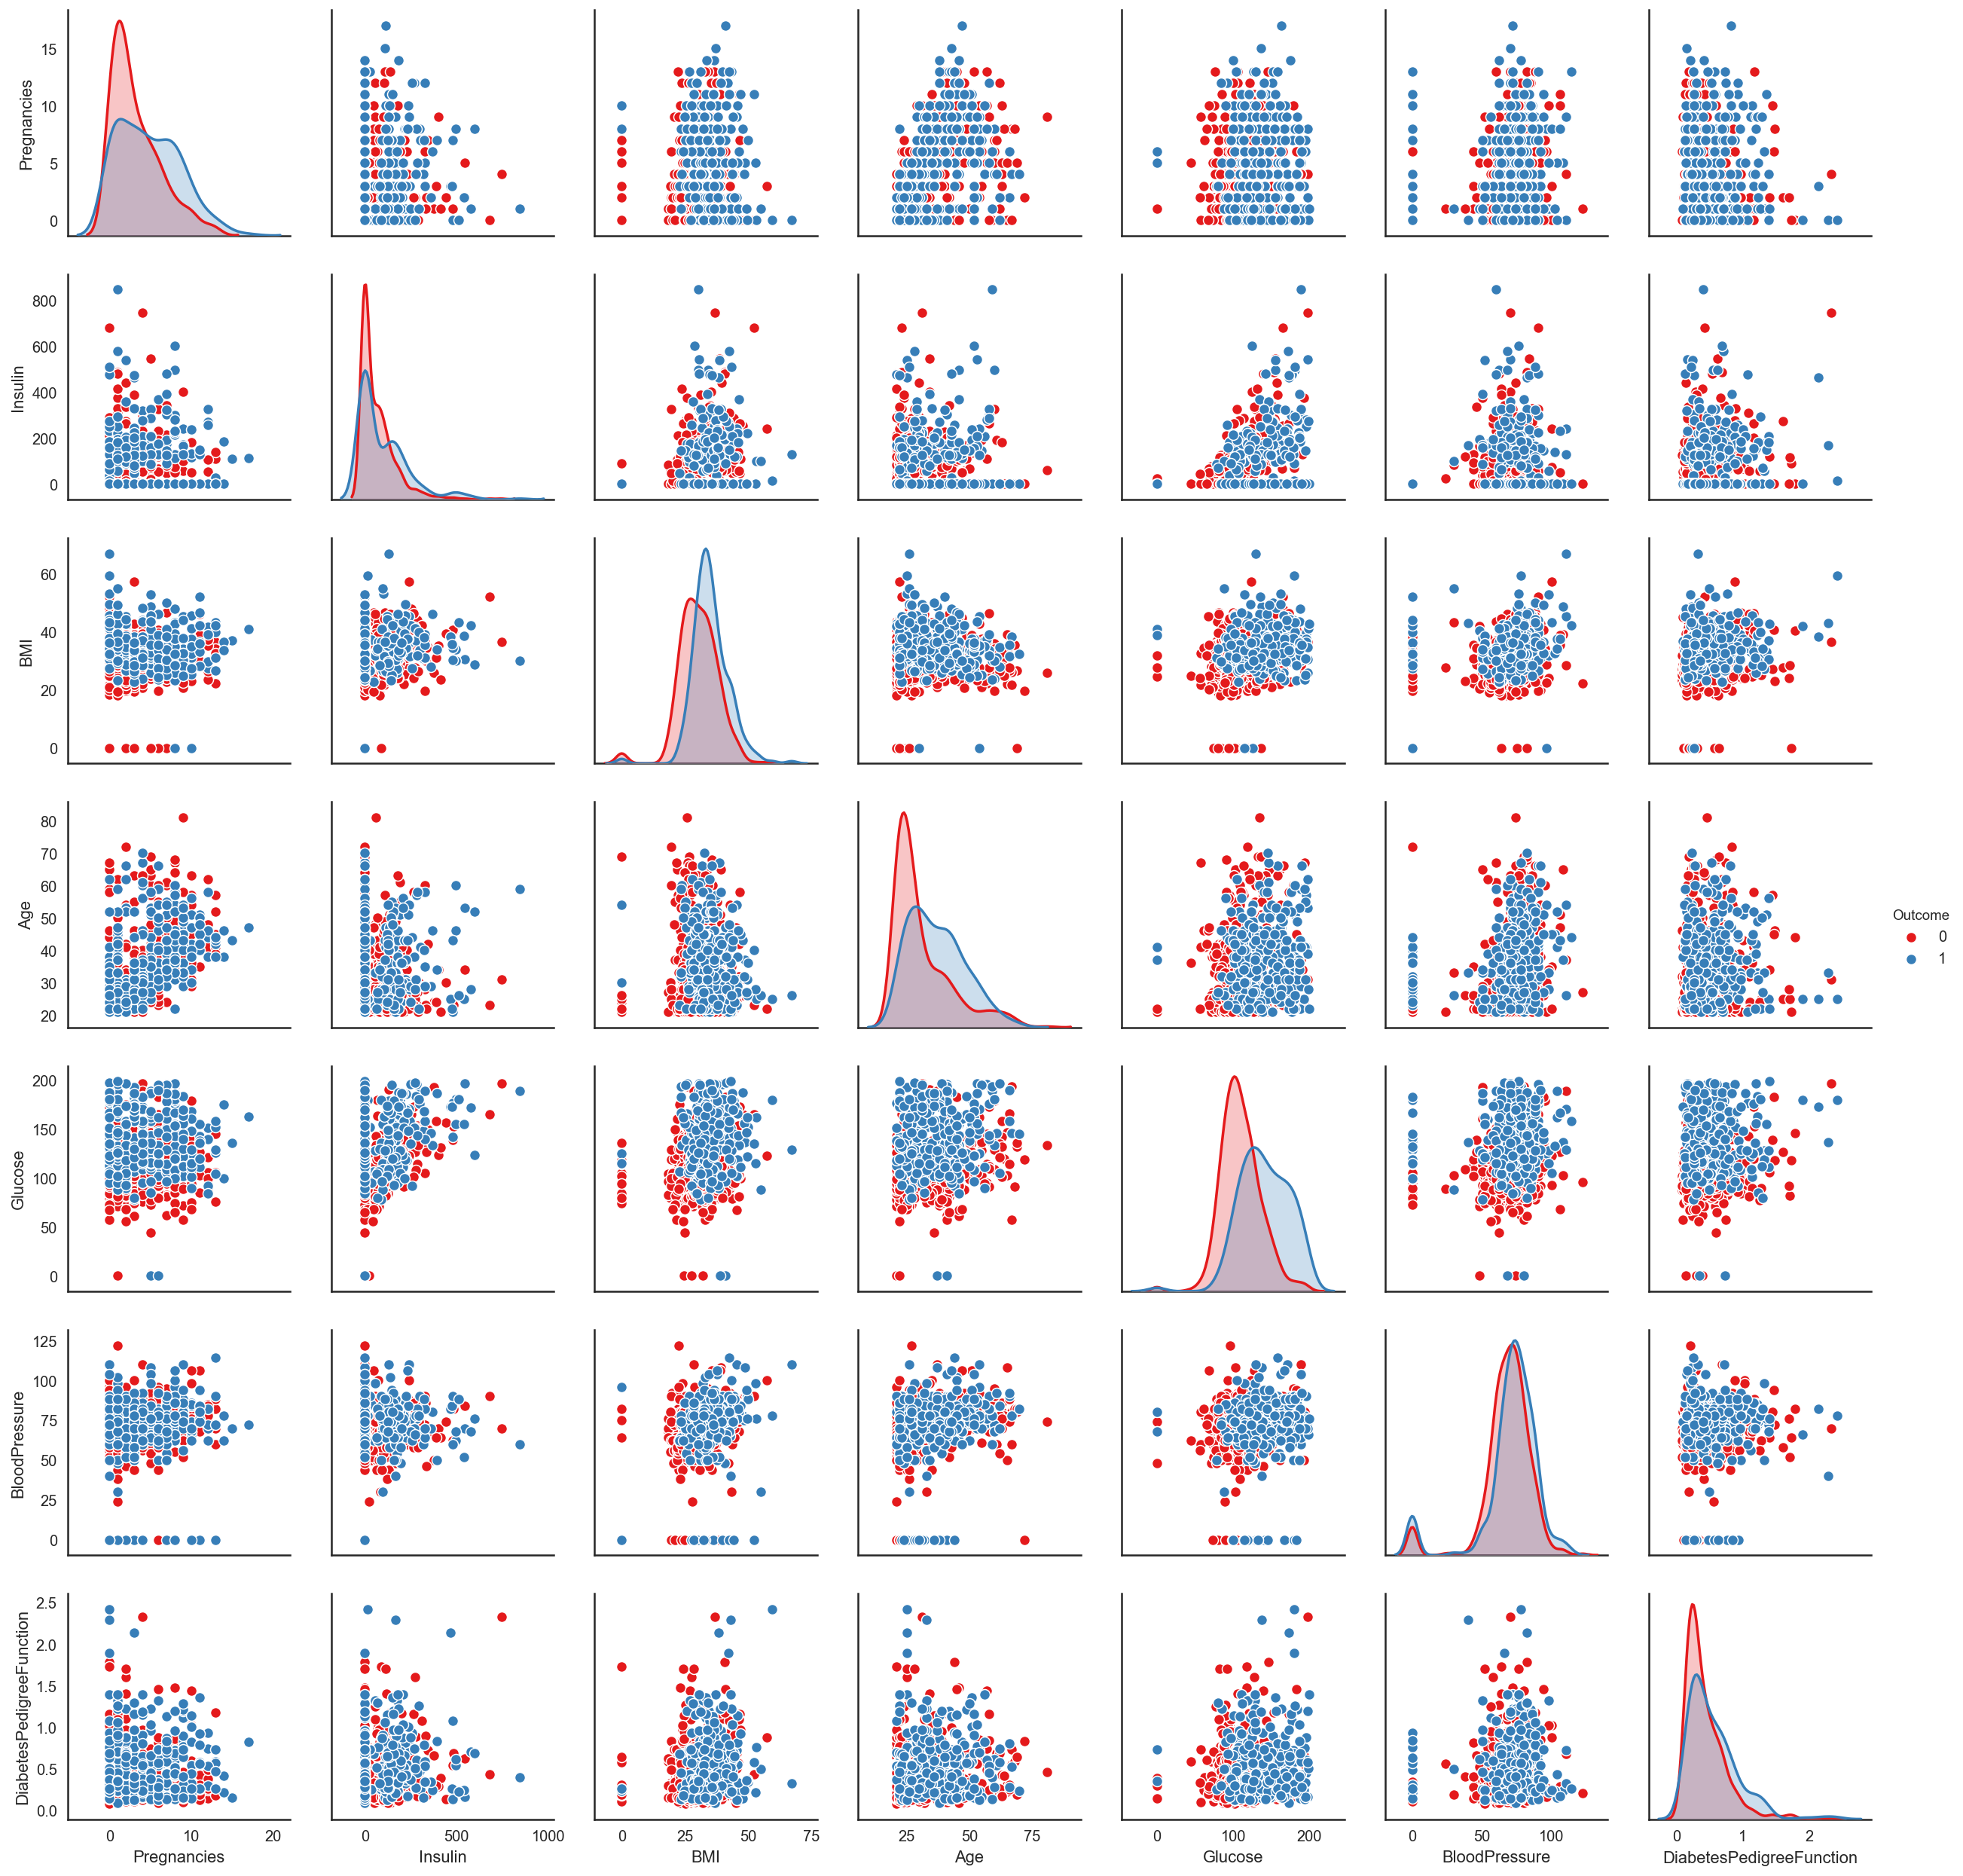

In [5]:
sns.pairplot(df, vars=features, hue='Outcome', palette='Set1');

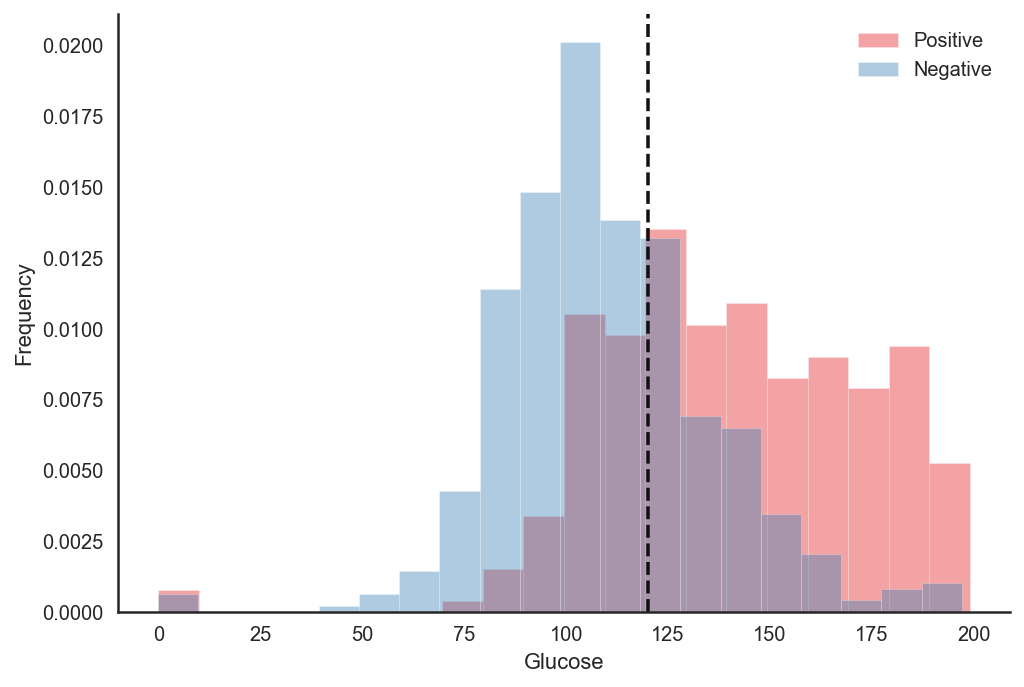

In [5]:
def dist_compare(df, feature, th, ax=None, title=None):
    if ax is None: fig, ax = plt.subplots()
    positive = df['Outcome'] == 1
    sns.distplot(df.loc[positive, feature], 20, norm_hist=True, color=red, label='Positive', kde=False, ax=ax)
    sns.distplot(df.loc[~positive, feature], 20, norm_hist=True, color=blue, label='Negative', kde=False, ax=ax)
    ax.axvline(th, color='k', ls='--')
    ax.legend()
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    sns.despine()
    
dist_compare(df, 'Glucose', 120)

# Decision tree classifier

How does a decision tree classifier work?

The idea is to construct a series of yes/no questions after which we make a prediction about the class.
Each question focuses on the values of a single feature, and the choice of question can depend on the answers to previous questions.

Let's look at the distributions to try to come up with such questions.

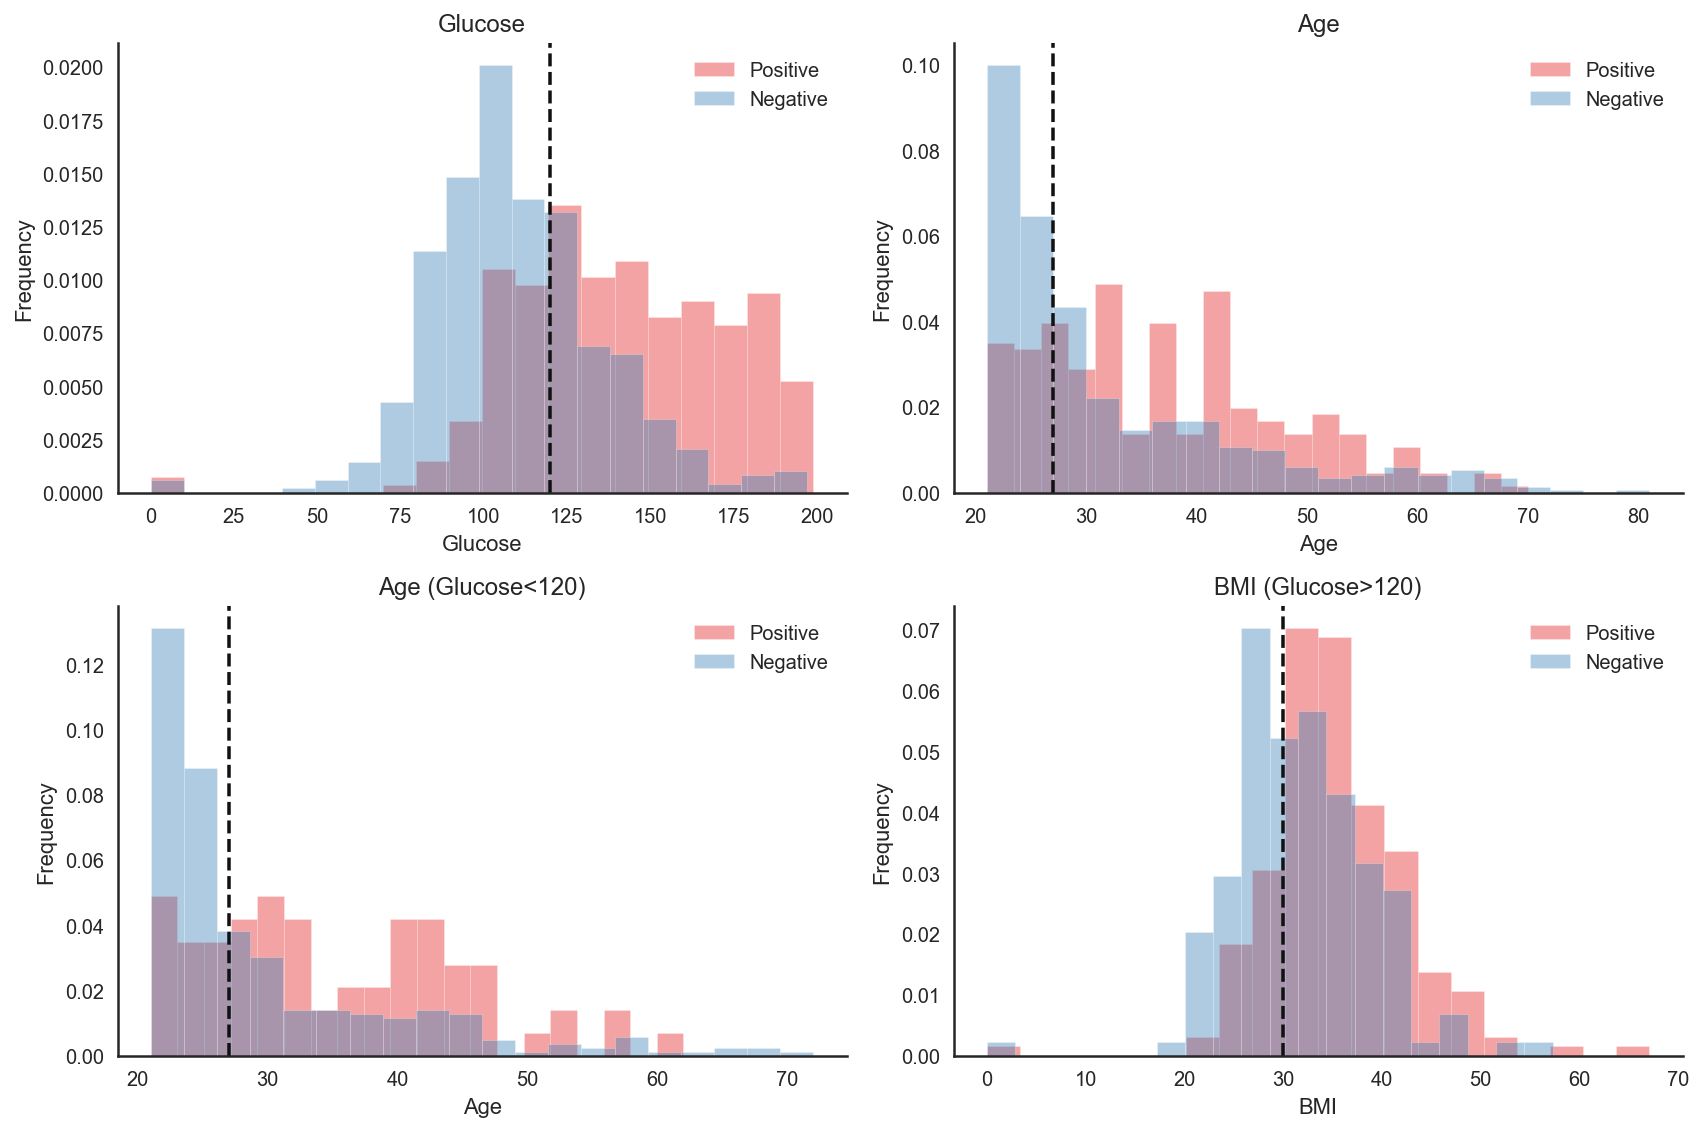

In [6]:
gluc_th = 120
fig, axes = plt.subplots(2, 2, figsize=(12, 8))    
dist_compare(df, 'Glucose', gluc_th, axes[0, 0], 'Glucose')
dist_compare(df, 'Age', 27, axes[0, 1], 'Age')
dist_compare(df[df['Glucose'] < gluc_th], 'Age', 27, axes[1,0], 'Age (Glucose<120)')
dist_compare(df[df['Glucose'] > gluc_th], 'BMI', 30, axes[1,1], 'BMI (Glucose>120)')
fig.tight_layout()

For this dataset, we might ask:
1. If Glucose below 120:
 1. If Age below 27: Negative
 1. Else: Positive
1. Else: 
 1. If BMI below 30: Negative
 1. Else: Positive
    
What is the accuracy of such a model?

In [7]:
def predict(df):
    return ((df['Glucose'] < 120) & (df['Age'] > 27)) | ((df['Glucose'] >= 120) & (df['BMI'] > 30))

yhat = predict(df)
print("Accuracy:", (yhat == df['Outcome']).mean())

Accuracy: 0.6458333333333334


Nice, with just these two questions we can have >50% accuracy (that is, non-random).

In order to come up with a series of such questions, the decision tree algorithm attempt to minimize the [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) of each additional "partition" made by the yes-no questions.

Gini impurity attempts to estimate the probability to make a classificaion error. That is, if the answer to some question determines the classification, what does the question need to be so that as many "positive" will be on one side, and as many "negatives" will be on the other side?

Let's use Scikit-learn to construct a decision tree.

In [8]:
classifier = DecisionTreeClassifier()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.683982683982684


This is only a bit better than our own improvised model.
What does this model actually do? Let's [visualize it](https://mljar.com/blog/visualize-decision-tree/).

In [9]:
print(tree.export_text(classifier, feature_names=features, max_depth=3))

|--- Glucose <= 129.50
|   |--- BMI <= 26.30
|   |   |--- BMI <= 9.10
|   |   |   |--- Age <= 28.00
|   |   |   |   |--- class: 0
|   |   |   |--- Age >  28.00
|   |   |   |   |--- class: 1
|   |   |--- BMI >  9.10
|   |   |   |--- DiabetesPedigreeFunction <= 0.67
|   |   |   |   |--- class: 0
|   |   |   |--- DiabetesPedigreeFunction >  0.67
|   |   |   |   |--- truncated branch of depth 2
|   |--- BMI >  26.30
|   |   |--- Age <= 27.50
|   |   |   |--- BMI <= 45.40
|   |   |   |   |--- truncated branch of depth 12
|   |   |   |--- BMI >  45.40
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- Age >  27.50
|   |   |   |--- DiabetesPedigreeFunction <= 0.56
|   |   |   |   |--- truncated branch of depth 12
|   |   |   |--- DiabetesPedigreeFunction >  0.56
|   |   |   |   |--- truncated branch of depth 9
|--- Glucose >  129.50
|   |--- BMI <= 27.85
|   |   |--- Glucose <= 145.50
|   |   |   |--- Age <= 59.50
|   |   |   |   |--- class: 0
|   |   |   |--- Age >  59.50
|   |   

We can also use the [dtreeviz](https://github.com/parrt/dtreeviz) library to create a very nice visualization. Note that installation can be a bit tricky.

The plot creates a flow chart with distributions and thresholds that show how the decision tree works.

In [10]:
from dtreeviz.trees import dtreeviz # requires installation, see https://github.com/parrt/dtreeviz

viz = dtreeviz(classifier, X, y, 
                target_name="Outcome",
                feature_names=features,
                class_names=["Negative", "Positive"])
viz

We can break down the classification errors using a nice plot from [yellowbrick](https://www.scikit-yb.org/en/latest/oneliners.html#classification) (install with `conda install -c districtdatalabs yellowbrick`).

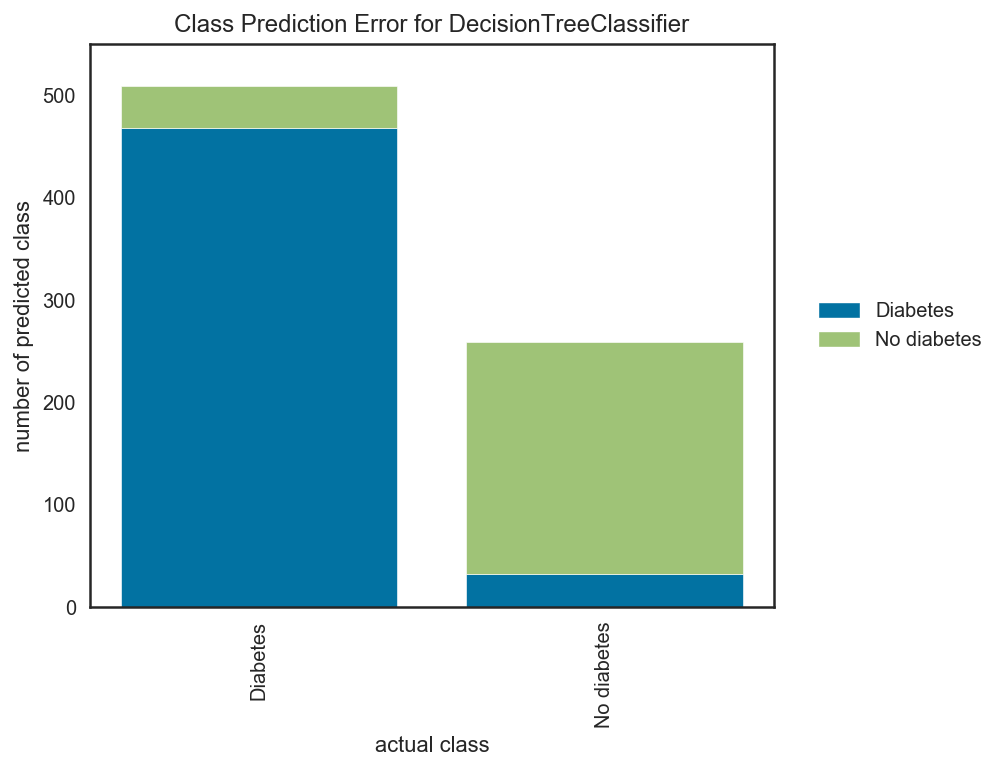

In [11]:
class_prediction_error(classifier, X, y, classes=['Diabetes', 'No diabetes'] );

The decision tree also allows us to inspect feature importance: which features has the greatest impact on the classification.

In [33]:
print(classifier.feature_importances_)

[0.04359331 0.04365493 0.1928899  0.10542158 0.31256198 0.14884071
 0.15303759]


Yellowbrick can [visualize](https://www.scikit-yb.org/en/latest/api/model_selection/importances.html) these  feature importances.

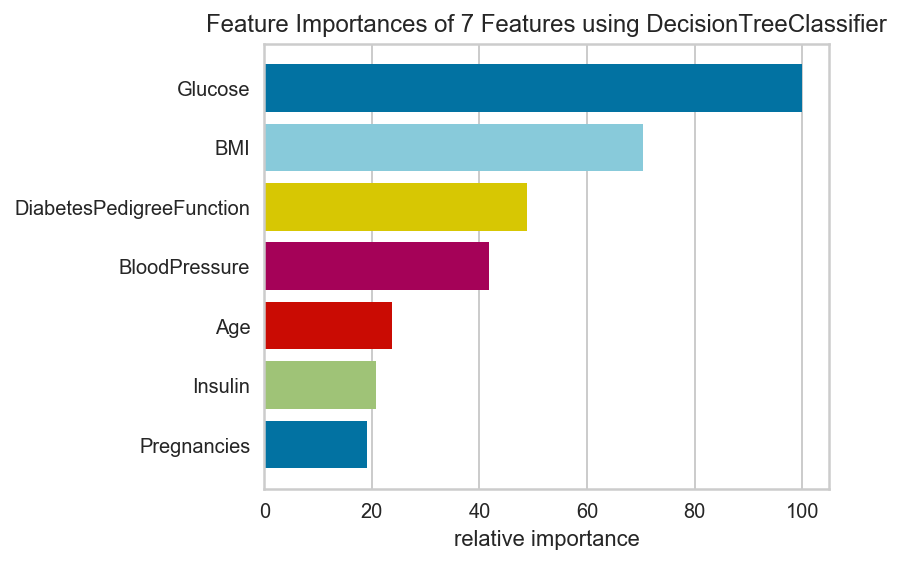

In [125]:
feature_importances(classifier, X, y, labels=features);

# Random Forest Classifier

As we saw, the decision tree only gave us accuracy of about 65%. How can we improve upon it?

A common way to improve it is to use a simple ensemble algorithm: [_Bagging_](https://en.wikipedia.org/wiki/Bootstrap_aggregating). 

In ensemble algorithms, a set of models is trained, and prediction is made using some decision rule on the set of predictions.

Bagging means that we train the same model, but each time with a different resample of the data.

Let's see how that works with just 3 trees - first by fitting each tree to a resample of the dataset.

In [37]:
trees = [DecisionTreeClassifier() for i in range(3)]
for tr in trees: # this can be parallelized
    n = X_train.shape[0]
    idx = np.random.choice(n, n, replace=True)
    X_, y_ = X_train[idx], y_train[idx]        
    tr.fit(X_, y_)

In [41]:
print("Accuracy: ")
for tr in trees:
    print(tr.score(X_test, y_test))

Accuracy: 
0.6493506493506493
0.70995670995671
0.645021645021645


Here's what each tree says for each sample in the test set (printing just the first 30 samples):

In [55]:
yhat = np.array([tr.predict(X_test) for tr in trees])
print(yhat[:, :30])

[[0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1]
 [0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0]]


We can then predict using a majority rule:

In [56]:
yhat = yhat.sum(axis=0) >= 2
yhat = yhat.astype(int)
print(yhat[:30])

[0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 0]


Amazingly, the accuracy of the ensemble is greater then the accuracy of any one tree:

In [57]:
print("Accuracy: ", (yhat == y_test).mean())

Accuracy:  0.7142857142857143


So, an ensemble of such trees is a **random forest**: forest because it has many trees, and random because each tree is trained on a random sample of the data.

We can use Scikit-learn's random forest classifier. If you want to use bagging with other models, there's a Scikit-learn's [ensemble module](https://scikit-learn.org/stable/modules/ensemble.html).

In [58]:
classifier = RandomForestClassifier(n_estimators=10)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7878787878787878


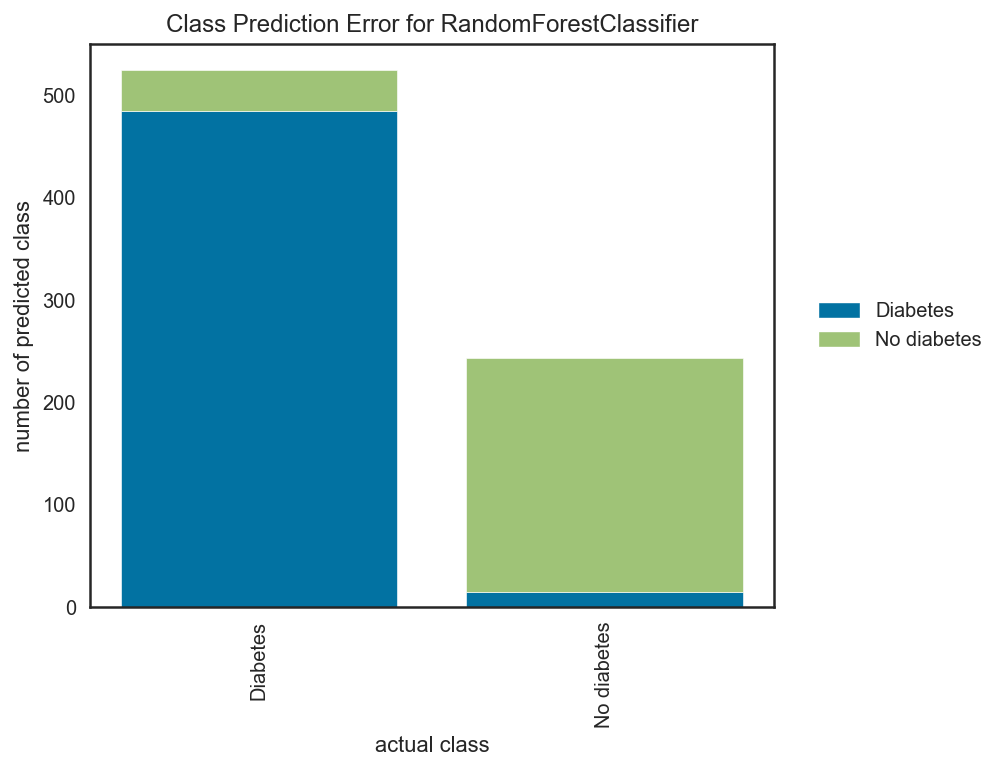

In [59]:
class_prediction_error(classifier, X, y, classes=['Diabetes', 'No diabetes'] );

How many trees should we use? The more the better? Are there diminishing returns? 
Each tree adds computational cost, both to the training and to the prediction, although much of the algorithm can be parallelised as different trees are independent.

We can use Yellowbrick to create a [validation curve](
https://www.scikit-yb.org/en/latest/api/model_selection/validation_curve.html#yellowbrick.model_selection.validation_curve.validation_curve), which uses cross-validation to train several models (here, random forest models), each with a different meta-parameter value (here, `n_estimators` that determines the number of trees in the forest), and displays the result.

As we can see, there seems to be diminishing returns, and using more than 20 trees doesn't seem to add much.

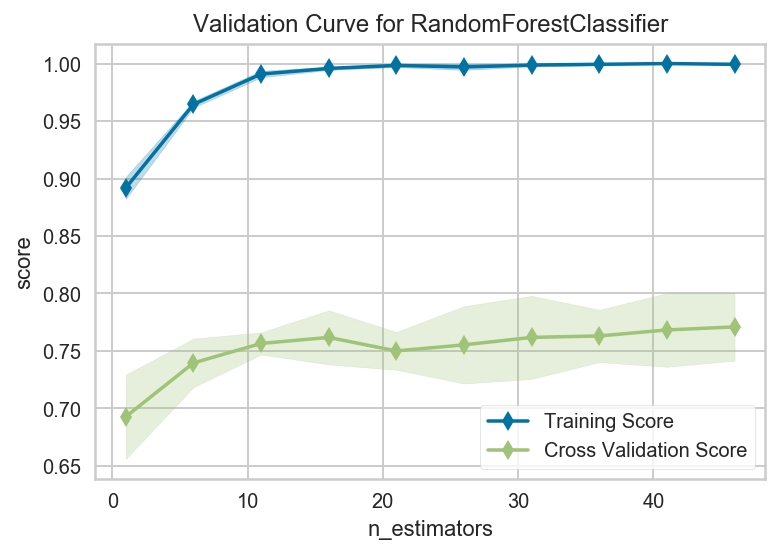

In [136]:
validation_curve(RandomForestClassifier(), X, y, 'n_estimators', range(1, 51, 5));

As mentioned above, we can use a `BagginClassifier`, and supply to it the underlying model we want to use (in this case, a `DecisionTreeClassifier`). This would give similar results to the `RandomForestClassifier`, although it may be a bit different due to some default hyper-parameter values.

In [60]:
classifier = BaggingClassifier(DecisionTreeClassifier(), 10)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7748917748917749


# Decision tree regressor

Decision trees can also be used for regression. In this case, the decision on each question is the mean of all the train examples that passed that question, and the alrogithm that builds the tree attempts to minimize the root mean squared error, similar to many regression models.

The data we use here is also a the [Boston house prices dataset](https://scikit-learn.org/stable/datasets/index.html#boston-dataset), in which we want to predict Median value of owner-occupied homes in $1000s from 13 features like per capita crime rate and pupil-teacher ratio. 

In [88]:
Xr, yr = load_boston(return_X_y=True)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.3)

In [89]:
regressor = DecisionTreeRegressor()
regressor.fit(Xr_train, yr_train)
# yr_hat = regressor.predict(Xr_test)
print("R2 = {:.3f}".format(regressor.score(Xr_test, yr_test)))

R2 = 0.825


The score is the coefficient of determination $R^2$, which measures the fraction of variance explained by the model.

We can use Yellowbrick's [residuals plot](https://www.scikit-yb.org/en/latest/api/regressor/index.html) to see how the residuals ($y-\hat{y}$) are distributed.

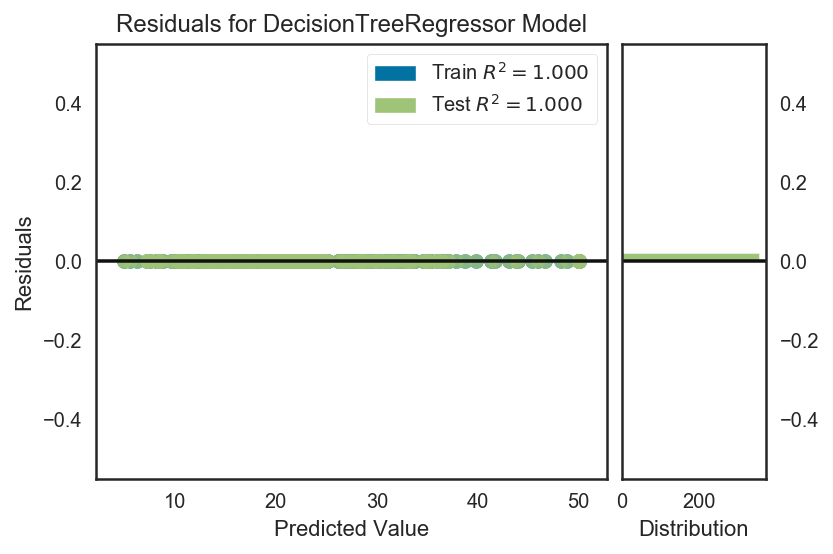

In [102]:
visualizer = residuals_plot(
    regressor, Xr_train, yr_train
);

We see the train values (although it says test, we only gave it train), which the tree **remembers** so the residuals are, of course, zero.

So let's focus on the test values (we could plot both train and test, but the distribution of the train hides information on the test).

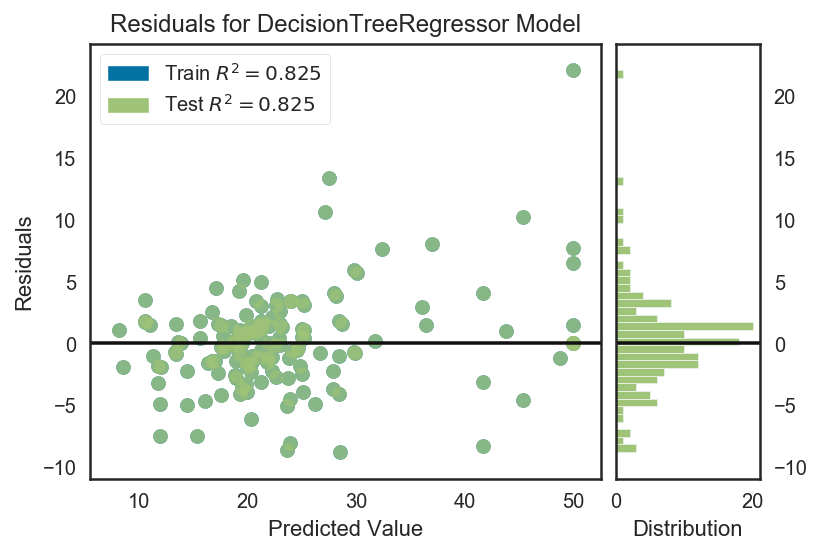

In [103]:
visualizer = residuals_plot(
    regressor, Xr_test, yr_test
);

These are dispersed nicely for predicted values < 30, but for higher predicted values the variance increases; this might be expected 

# Random forest regressor

We can, of course, use a random forest for this task. Here, it takes the average prediction of the ensemble rather than the majority.

In [106]:
regressor = RandomForestRegressor()
regressor.fit(Xr_train, yr_train)
# yr_hat = regressor.predict(Xr_test)
print("R2 = {:.3f}".format(regressor.score(Xr_test, yr_test)))

R2 = 0.882


The $R^2$ is higher. 

Let's look at the residuals. This time it makes sense to look at the train, not just the test, examples, because we would like to see how much the forest is better on one compared to the other. Each tree "remembers" all the train values, but the ensemble aggregates these "memories".

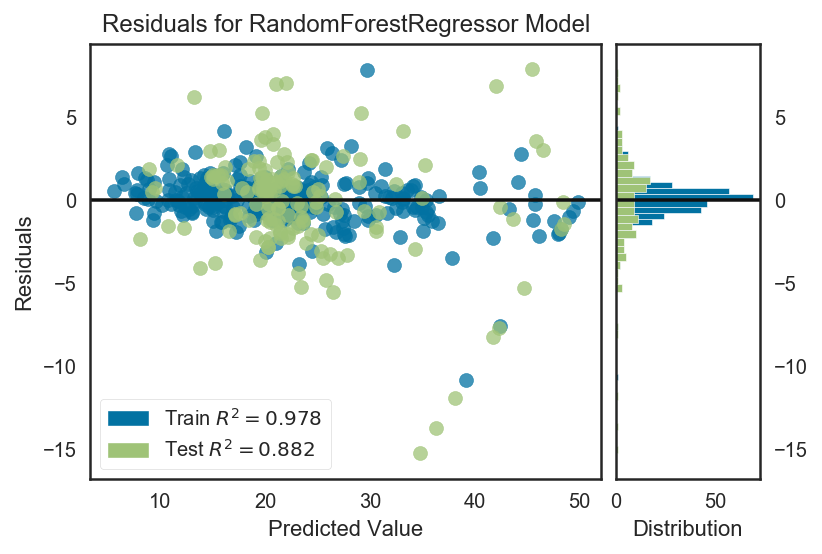

In [107]:
visualizer = residuals_plot(
    regressor, Xr_train, yr_train, Xr_test, yr_test
);

This is pretty good, we can see again that below a value of 30 the model works well, and that there are some values in which the residuals are negative (under-estimation), but that also happens for the (blue) train values, so it's not a test set problem.

# Decision trees from scratch

In the next sections we implement everything "by hand" using NumPy to provide a deeper look at how the algorithms work.

## Decision tree classifier

Influenced by [blog post in Curiousily](https://www.curiousily.com/posts/build-a-decision-tree-from-scratch-in-python/).
For simplicity, we focus on binomial classification, but everything easily extends to multinomial classification.

The decision tree is a binary tree.
Each branching node $n$ specifies a specific feature $j_n$ and a split value $x_n$.
Each leaf $l$ specifies a classification prediction $p_l$, i.e. the probability that the correct class if "1".

When the decision tree is used for prediciton, we start we a set of feature values $X=(x_1, \ldots, x_M)$ at the root of the tree, so we start at node $n=0$.
We then iteratively traverse the tree until we reach a leaf by choosing the left branch if the value of this node's feature is less than this node's split value:
$$
x_{j_n} < x_n,
$$
and otherwise we choose the right branch.
When we find a leaf $l$, we use that leaf's classification prediction $p_l$.

How is the tree constructed?
We present a simple algorithm, but more sophisticated ones exist.

We start with the root branch, $n=0$ with all our examples $i=1,2,\ldots,N$.

We want to choose a feautre $j_n$ and split value $x_n$ that, if we branch with this feaure and split value, we will minimize some loss function. This loss function is computed on both branches, and we use the  weighted average of the losses on both branches. We will discuss the specific loss function later.

To do this, we iterate over all $M$ features, and for every feature, on all $Nn$ samples, and for each sample $i$ of each feature $j$, we branch the set of examples, compute the loss for each branch, and compute the average loss.
We choose the feature and split value that gave the minimal loss, and set them as the feautre $j_n$ and spit value $x_n$ of this node.

Then we branch the examples to those below and those above the split value, and we create two new nodes $n_L$ and $n_R$, the left node $n_L$ for the "below" values, and the right node $n_R$ for the "above" value.
We then repeat the whole process for both nodes.
So this is a greedy recursive algorithm (and we can probably make it more efficient or at least parallelize it).

Like any recursion we must have a stop condition. When do we stop? When the number of examples in a node raches some minimial value `min_leaf`, we call that node a leaf.

Thats it. We implement this in the `Node` class.

In [108]:
class Node:
    def __init__(self, x, y, loss_func, min_leaf=5):
        ''' x: data, rows for samples, columns for features
            y: labels, rows for samples
            min_leaf: number of samples in node to make it a leaf
        '''
        # it is a leaf unless we decide otherwise
        self.is_leaf = True
        # set the value to average y / fraction of 1s in y, in case this is a leaf
        self.value = y.mean()
        
        # look for the feature (column or j) and split value that give the lowest loss
        best_j, best_split, best_loss = 0, np.inf, np.inf
        # iterate over columns looking for a good feature
        for j in range(x.shape[1]):
            xj = x[:, j]
            # iterate over rows looking for a good split - this can be parallelized
            for xij in xj:
                left_idx = xj <= xij
                right_idx = ~left_idx # rhs = not lhs
                # if either side is too small, go to next split
                if left_idx.sum() < min_leaf:
                    continue
                if right_idx.sum() < min_leaf:
                    continue
                # compute score
                loss_ij = loss_func(y[left_idx], y[right_idx])
                # if this is the lowest loss so far, save it
                if loss_ij < best_loss:
                    best_loss = loss_ij
                    best_split = xij
                    best_j = j
        # no loss found, its a leaf, finish 
        if np.isinf(best_loss):
            return
        # loss was found, save to attributes
        self.is_leaf = False
        self.feature = best_j
        self.split = best_split
        
        # prepare to branch the tree
        xj = x[:, best_j]
        lhs = np.nonzero(xj <= best_split)[0]
        rhs = np.nonzero(xj > best_split)[0]
        # branch the tree to left and right
        self.left = Node(x[lhs, :], y[lhs], loss_func, min_leaf)
        self.right = Node(x[rhs, :], y[rhs], loss_func, min_leaf)
    
    
    def predict(self, x):
        if self.is_leaf:
            return self.value
        
        if x[self.feature] <= self.split:
            return self.left.predict(x)
        else:
            return self.right.predict(x)

The loss function we will use is called [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity). 

For simiplicity, let's assume binomial classifcation, i.e. only two possible class (this can easily be extended to more then two classes).
Gini impurity attempts to estimate the probability to make a classificaion error.
We assume set of $n$ elements, of which $p_0$ are of class "0" (e.g. fail) and $p_1$ are of class "1" (e.g. success).
Without any other information, we have a $p_0$ chance to say that a random element is "0" and $p_1$ chance to say it is "1". 
So the Gini impurity is

$$
\text{gini} = P(\text{draw}\; 0, \text{say}\; 1) + P(\text{draw}\; 1, \text{say}\; 0) = \\
p_0 p_1 + p_1 p_0 = p_0 (1-p_0) + p_1 (1-p_1) = p_0 + p_1 - p_0^2 - p_1^2 = \\
1 - (p_0^2 +p_1^2)
$$

In [109]:
def gini(y_left, y_right):
    p1_left = y_left.mean() # frequency of 1s
    p0_left = 1 - p1_left # frequency of 0s
    gini_left = (1 - (p0_left * p0_left + p1_left * p1_left))
    p1_right = y_right.mean()
    p0_right = 1 - p1_right
    gini_right = (1 - (p0_right * p0_right + p1_right * p1_right))
    return gini_left * len(y_left) + gini_right * len(y_right)

We now wrap the whole thing in a Scikit-learn-like classifier object that has a constructor method `__init__`, a `fit` method, and a `predict` method.

In [110]:
class MyDecisionTreeClassifier:
    def __init__(self, min_leaf=5):
        self.min_leaf = min_leaf
        
    def fit(self, X, y):
        self.threshold = y.mean()
        self.root = Node(X, y, loss_func=gini, min_leaf=self.min_leaf)
        return self
    
    def predict(self, X):
        return np.array([
            self.root
            .predict(x) > self.threshold 
            for x in X
        ])

In [111]:
classifier = MyDecisionTreeClassifier()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7229437229437229


## Random forest classifier

Similarly to above, we create several trees and train them; when predicting we take the majority rule.

In [112]:
class MyRandomForestClassifier:
    def __init__(self, n_trees=10, min_leaf=5):
        self.n_trees = n_trees
        self.min_leaf = min_leaf
        self.trees = [MyDecisionTreeClassifier() for i in range(n_trees)]
        
    def fit(self, X, y):
        for i in range(self.n_trees): # this can be parallelized
            n = X_train.shape[0]
            idx = np.random.choice(n, n, replace=True)
            X_, y_ = X_train[idx], y_train[idx]        
            self.trees[i].fit(X_, y_)
        return self
    
    def predict(self, X):
        pred = np.array([tree.predict(X) for tree in self.trees])
        values, counts = np.unique(pred, return_counts=True, axis=0)
        ind = np.argmax(counts)
        return values[ind]  

In [113]:
classifier = MyRandomForestClassifier(10)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7229437229437229


## Decision tree regressor

Here we just need to update the loss function to `rmse`.

In [114]:
def rmse(y_left, y_right):
    # minimizing weighted averages of the standard deviations is equivalent to minimizing RMSE
    return y_left.std() * len(y_left) + y_right.std() * len(y_right)

class MyDecisionTreeRegressor:
    def fit(self, X, y, min_leaf=5):
        self.dtree = Node(X, y, loss_func=rmse, min_leaf=min_leaf)
        return self
    
    def predict(self, X):
        return np.array([self.dtree.predict(x) for x in X])

In [118]:
regressor = MyDecisionTreeRegressor()
regressor.fit(Xr_train, yr_train)
yr_hat = regressor.predict(Xr_test)
print("R2 = {:.3f}".format(r2_score(yr_test, yr_hat)))

R2 = 0.738


# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

The notebook was written using [Python](http://python.org/) 3.7.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)